# Feature Engineering - Are these features worth existing?

In [1]:
# 3rd Party
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# linear_regression_001
from linear_regression_001.data.loader import load_clean_data
from linear_regression_001.features.build_features import split_features_target, build_features, build_preprocessor, FEATURE_LIST
from linear_regression_001.utils.paths import PROCESSED
from linear_regression_001.utils.regression_tests import calculate_vif, plot_feature_correlations, plot_linearity_checks

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler # Assumes all numeric columns. Encode categorical first.
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split

# Post training - If performance drops, the model relied on it
from sklearn.inspection import permutation_importance


## Purpose: 
1. Experiment with feature ideas
2. Test if they help
3. Visualize impact
4. Iterate

If the feature is "approved" it graduates to build_features.py
This notebook is used to explore to see which features to use and how to apply logic. All defined in build_features.py

The engineered features MUST be created the same way for training, prediction, and evaluation.
Therefore, the logic must live in the code.

Output: 
- Save data that was cleaned with the engineered features, but these are still "raw" in ML terms.
- This means that there is no encoding or scaling or any train/test leakage from this output dataset.

## Linear Regression Assumptions: 
### Can I transform variables so assumptions are more plausible?
1. log-transform skewed variables
2. create interaction terms
3. add polynomial terms
4. remove redundant predictors
5. standardize features
6. engineer ratios instead of raw values
### The tests are only raw features and target variable with no fitting required like multicollinearity and linearity.
### Like a quality check to see if features are suitable inputs for linear regression.

In [5]:
# ================================================================
# STEP 1: Load Data
# ================================================================
df = load_clean_data('cleaned_insurance.csv')
X, y = split_features_target(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



## Feature Engineering


In [6]:
# ================================================================
# STEP 2: Feature Building Section - Prototype new features here!
# ================================================================

def build_prototype_features(df):
    """
    Build all features you want to test.
    Add/remove/modify features here before committing to build_features.py
    """
    df = df.copy()
    features = pd.DataFrame(index=df.index)

    # --- Raw Features ---
    features['age'] = df['age']
    features['bmi'] = df['bmi']
    features['children'] = df['children']
    features['region'] = df['region']
    features['smoker'] = df['smoker']
    features['sex'] = df['sex']

    # --- Engineered Features (prototype here!) ---

    # Log transformations
    # features['log_bmi'] = np.log1p(df['bmi'])

    # Polynomial features
    # features['age_sq'] = df['age'] ** 2

    # Interaction terms
    features['bmi_smoker'] = df['bmi'] * (df['smoker']=='yes').astype(int)

    # Regional features
    # features['east'] = ((df['region']=='northeast') | (df['region']=='southeast')).astype(int)
    # features['southeast'] = (df['region']=='southeast').astype(int)

    # Age bins
    # BMI categories

    return features

In [7]:
# ================================================================
# STEP 3: Feature Selection for Testing
# ================================================================

def select_features(df, feature_names):
    """Select specific columns from the built features"""
    return df[feature_names]


# Baseline: current best feature set
baseline_feature_names = ["age", "bmi", "children", "smoker", "region", "sex"]

# Candidate: add new features you want to test
candidate_feature_names = ["age", "bmi", "sex", "smoker", "children", "region", "bmi_smoker"]

### Pre-processor: Linearity, VIF, and Correlation Check 

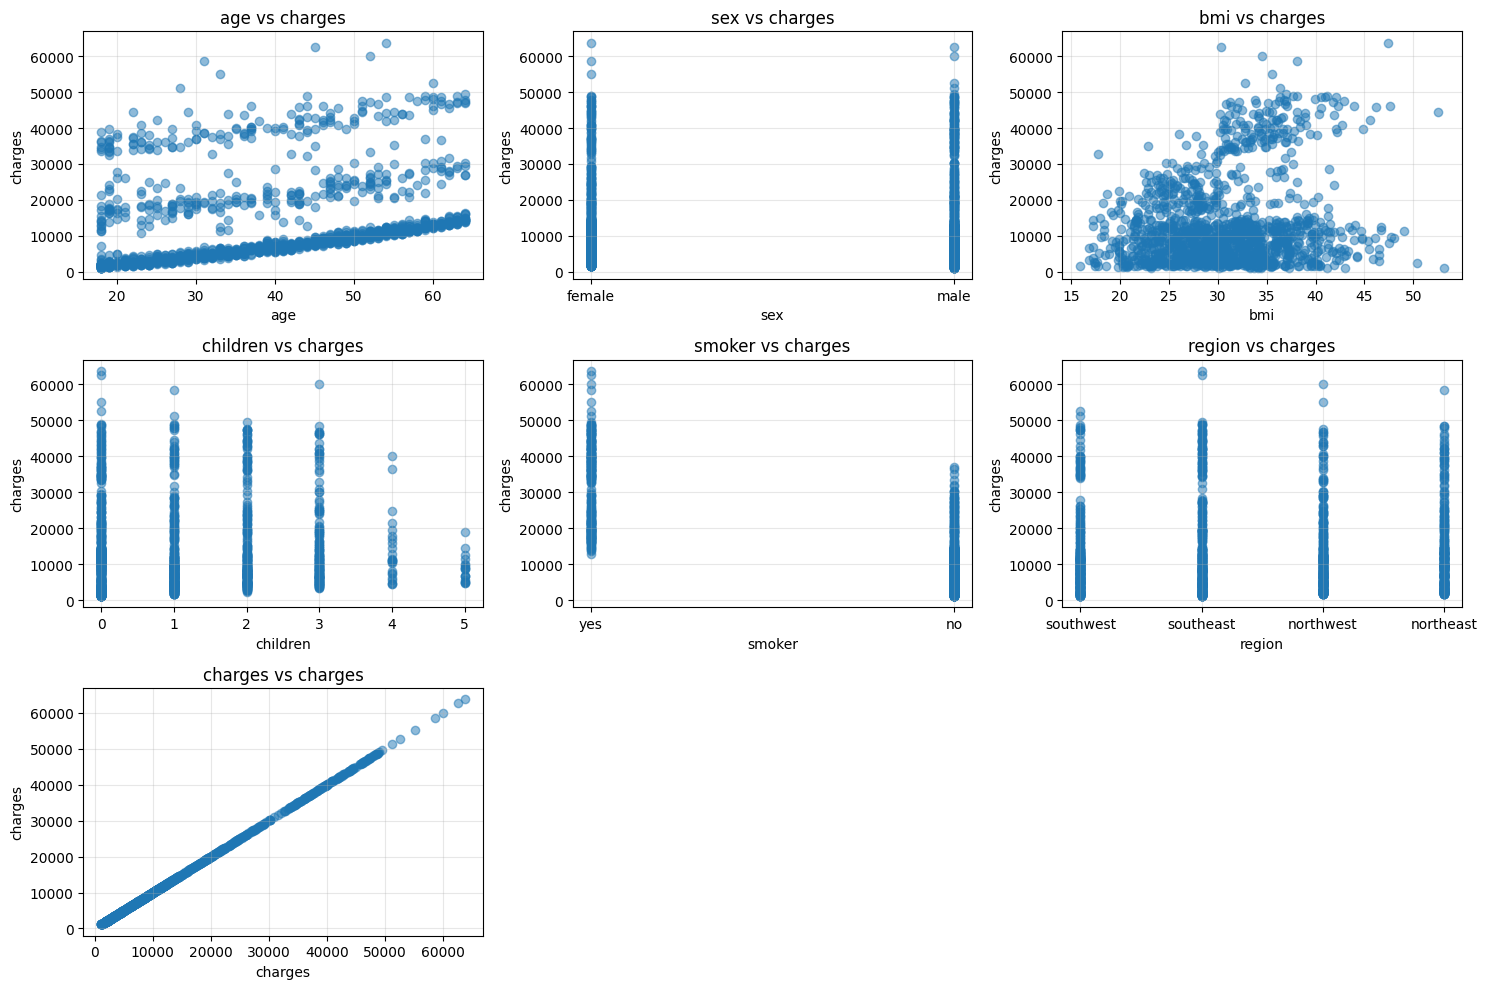

In [8]:
plot_linearity_checks(df,df.iloc[:,:].columns.to_list(),'charges')

In [9]:
# VIF test before preprocessing -- Note that VIF will be high for interaction terms.
all_features = build_prototype_features(X_train)
selected_features = select_features(all_features, candidate_feature_names)
vif_results = calculate_vif(selected_features, candidate_feature_names)
print(vif_results)


      Feature       VIF
1         bmi  8.255996
0         age  7.715123
2    children  1.797035
3  bmi_smoker  1.247998


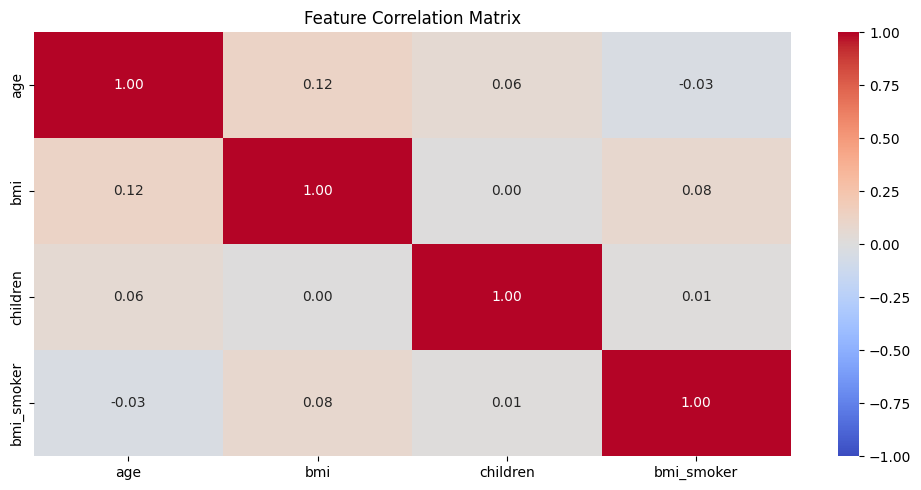

In [10]:
plot_feature_correlations(selected_features,candidate_feature_names)

In [11]:
# ================================================================
# STEP 4: Preprocessor
# ================================================================
class DynamicPreprocessor(BaseEstimator, TransformerMixin):
    """A custom transformer in pipeline:
        - BaseEstimator allows get and set params for hyperparameter tuning
        - TransformerMixin allows to add fit_transform to class
    Preprocessor that detects numeric/categorical columns dynamically"""

    def __init__(self):
        self.preprocessor = None
        self.feature_names_in_ = None
        self.feature_names_out_ = None

    def fit(self, X, y=None):
        # Must return self for method chaining like predict() or transform()
        self.feature_names_in_ = X.columns.tolist()

        num_cols = X.select_dtypes(include='number').columns.to_list()
        cat_cols = X.select_dtypes(exclude='number').columns.to_list()

        transformers = []
        if num_cols:
            transformers.append(('num', StandardScaler(), num_cols))
        if cat_cols:
            transformers.append(('cat', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), cat_cols))


# FIXED: If no transformers, just pass through
        if not transformers:
            transformers.append(('passthrough', 'passthrough', X.columns.to_list()))

        self.preprocessor = ColumnTransformer(
            transformers=transformers,
            remainder='drop'  # FIXED: Changed from 'passthrough'
        )

        self.preprocessor.fit(X)

        self.feature_names_out_ = self.preprocessor.get_feature_names_out()

        return self

    def transform(self, X):
        # Return transformed logic
        return self.preprocessor.transform(X)

    def get_feature_names_out(self):
        """Return feature names after transformation"""
        if self.feature_names_out_ is None:
            raise AttributeError("Preprocessor has not been fitted yet. Call fit() first.")
        return self.feature_names_out_

In [12]:
# ================================================================
# STEP 5: Custom Feature Builder for Notebook Testing
# ================================================================

class NotebookFeatureBuilder(BaseEstimator, TransformerMixin):
    """A custom transformer in pipeline:
        - BaseEstimator is used to get and set params for hyperparameter tuning
        - TransformerMixin allows for fit_transform
    Uses the notebook's build_prototype_features function, i.e.,
    given a dataframe output a dataframe with desired feature_names"""

    def __init__(self, feature_names):
        self.feature_names = feature_names

    def fit(self, X, y=None):
        # returns self to allow chaining like predict() or transform()
        return self

    def transform(self,X):
        # returns transformed logic
        all_features = build_prototype_features(X)
        return select_features(all_features, self.feature_names)

### Post-processor: Linearity, VIF, and Correlation Check 

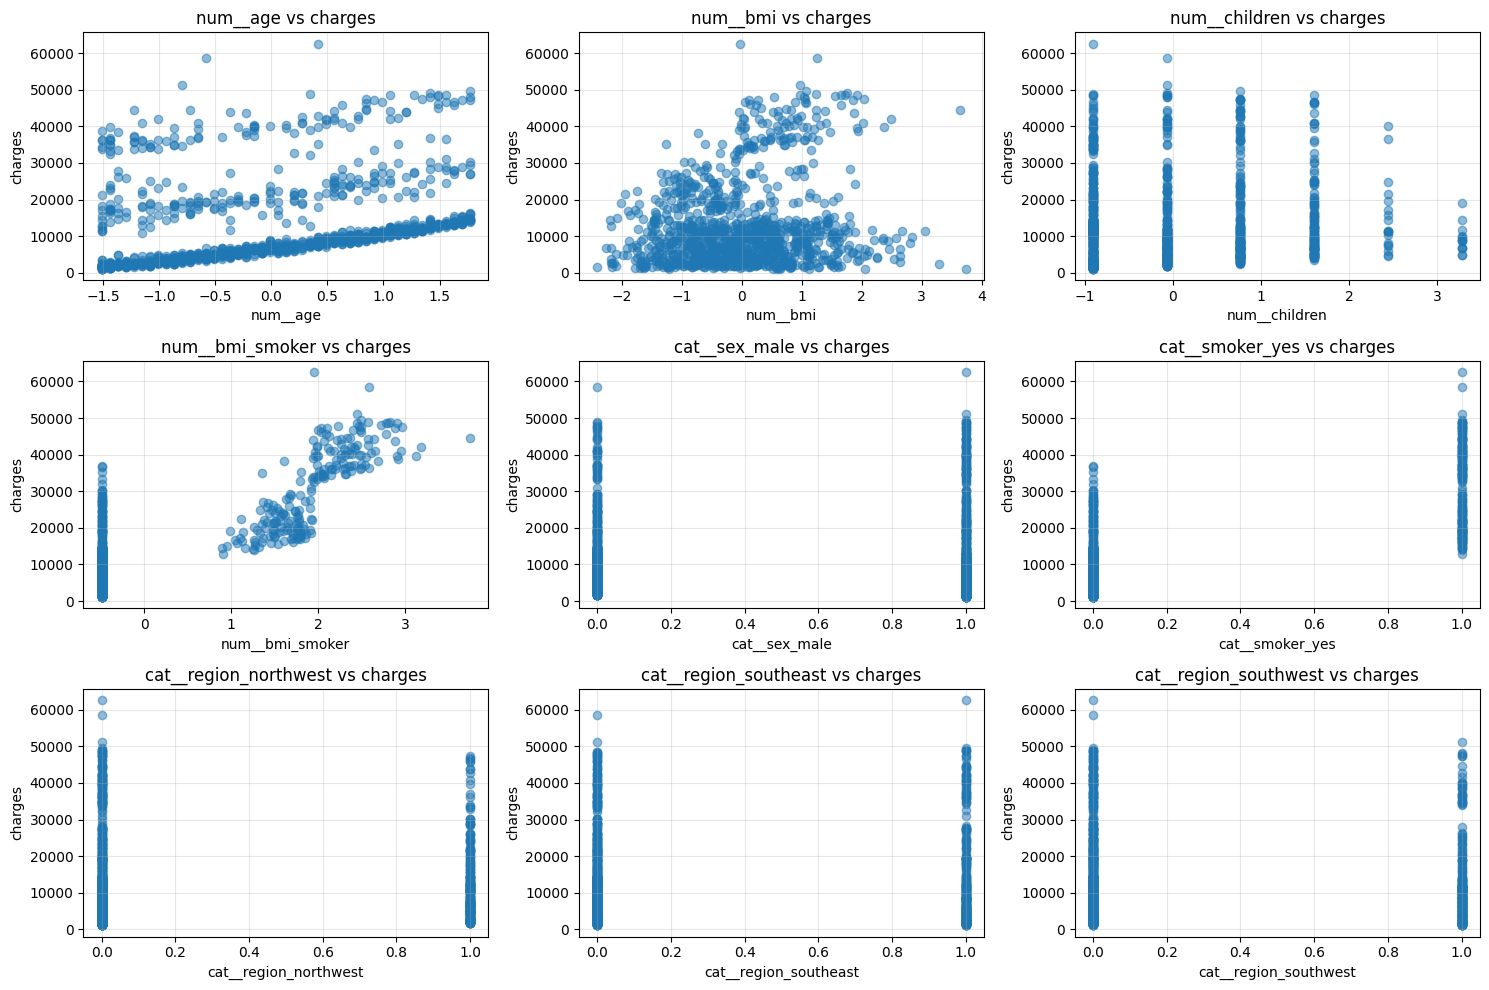

In [36]:
# Get features
all_features = build_prototype_features(X_train)
selected_features = select_features(all_features, candidate_feature_names)
# Preprocessor setup to get names
preprocessor = DynamicPreprocessor()
preprocessor.fit(selected_features)
X_train_processed = preprocessor.transform(selected_features)
feature_names_out = preprocessor.get_feature_names_out()
# Build DataFrame
X_train_df = pd.DataFrame(X_train_processed, columns = feature_names_out,index=selected_features.index)
train_df = pd.concat([X_train_df,y_train],axis=1)

plot_linearity_checks(train_df,feature_names_out,'charges')


In [37]:
# Calculate VIF
vif_results = calculate_vif(X_train_df)
print(vif_results)

                 Feature        VIF
5        cat__smoker_yes  14.219546
3        num__bmi_smoker  11.836670
7  cat__region_southeast   1.857260
4          cat__sex_male   1.844678
6  cat__region_northwest   1.673823
8  cat__region_southwest   1.648830
1               num__bmi   1.295506
0               num__age   1.025627
2          num__children   1.004984


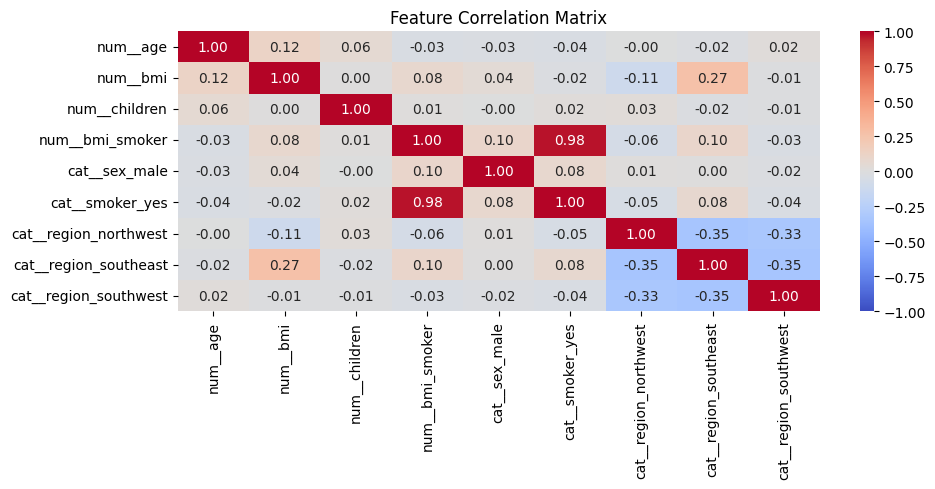

In [38]:
plot_feature_correlations(train_df,feature_names_out)

In [10]:
# ================================================================
# STEP 6: Cross-Validation Testing
# ================================================================
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scoring = "neg_root_mean_squared_error"

def test_features(feature_names, label="Model"):
    """Test a feature set and return RMSE scores"""
    pipeline = Pipeline(steps=[
        ("features", NotebookFeatureBuilder(feature_names)),
        ("preprocessor", DynamicPreprocessor()),
        ("model", LinearRegression())
    ])

    scores = cross_val_score(
        pipeline, X_train, y_train,
        cv = cv,
        scoring = scoring
    )

    rmse_scores = -scores
    print(f"\n{label}")
    print(f"Mean RMSE: {rmse_scores.mean():,.2f}")
    print(f"Std RMSE: {rmse_scores.std():,.2f}")
    print(f"Per fold: {rmse_scores}")

    return rmse_scores

In [11]:
# ================================================================
# STEP 7: Run the Comparison
# ================================================================
print("="*60)
print("Feature Comparison")
print("="*60)

baseline_scores = test_features(baseline_feature_names, "BASELINE")
candidate_scores = test_features(candidate_feature_names, "CANDIDATE")

Feature Comparison

BASELINE
Mean RMSE: 6,123.65
Std RMSE: 189.30
Per fold: [5846.90224943 6003.92136769 6130.96675099 6239.25754263 6397.2085076 ]

CANDIDATE
Mean RMSE: 4,943.01
Std RMSE: 134.19
Per fold: [4996.35756631 4778.022814   4792.48250572 5035.80660599 5112.39763995]


In [81]:
# ================================================================
# STEP 8: Evaluate Results
# ================================================================

improvement = baseline_scores - candidate_scores
positive_folds = sum(1 for i in improvement if i > 0)
relative_improvement = improvement.mean() / baseline_scores.mean()

print("\n" + "="*60)
print("RESULTS")
print("="*60)
print(f"Mean improvement: {improvement.mean():,.2f}")
print(f"Relative improvement: {relative_improvement:.2%}")
print(f"Folds improved: {positive_folds}/{len(improvement)}")

print("\n" + "="*60)
print("DECISION")
print("="*60)

if positive_folds >= 3 and relative_improvement >= 0.01:
    print("✓ ACCEPT - Add this feature to build_features.py!")
    print("\nNext steps:")
    print("1. Copy the feature function to build_features.py")
    print("2. Add it to FEATURE_REGISTRY")
    print("3. Update your baseline_feature_names for next comparison")
elif positive_folds >= 3:
    print("⚠ MARGINAL - Improved most folds but <1% gain")
    print("Consider: Is the added complexity worth it?")
elif relative_improvement >= 0.01:
    print("⚠ MARGINAL - Good average but inconsistent across folds")
    print("Consider: Why isn't it working on all folds?")
else:
    print("✗ REJECT - This feature doesn't help")
    print("Try: Different transformations or interactions")

print("="*60)


RESULTS
Mean improvement: 1,180.64
Relative improvement: 19.28%
Folds improved: 5/5

DECISION
✓ ACCEPT - Add this feature to build_features.py!

Next steps:
1. Copy the feature function to build_features.py
2. Add it to FEATURE_REGISTRY
3. Update your baseline_feature_names for next comparison



Permutation Importance: CANDIDATE with bmi_smoker

Top Features by Permutation Importance:
        features  importance_mean  importance_std
      bmi_smoker     24515.961148      684.877724
      smoker_yes      8705.712648      312.668551
             age      2485.084759      171.822794
        children        83.183409       31.341898
region_southwest        71.596281       25.612749
region_southeast        66.368470       29.056805
region_northwest         0.826871       15.569626
             bmi         0.643879        5.474439
        sex_male        -9.036881       12.835179


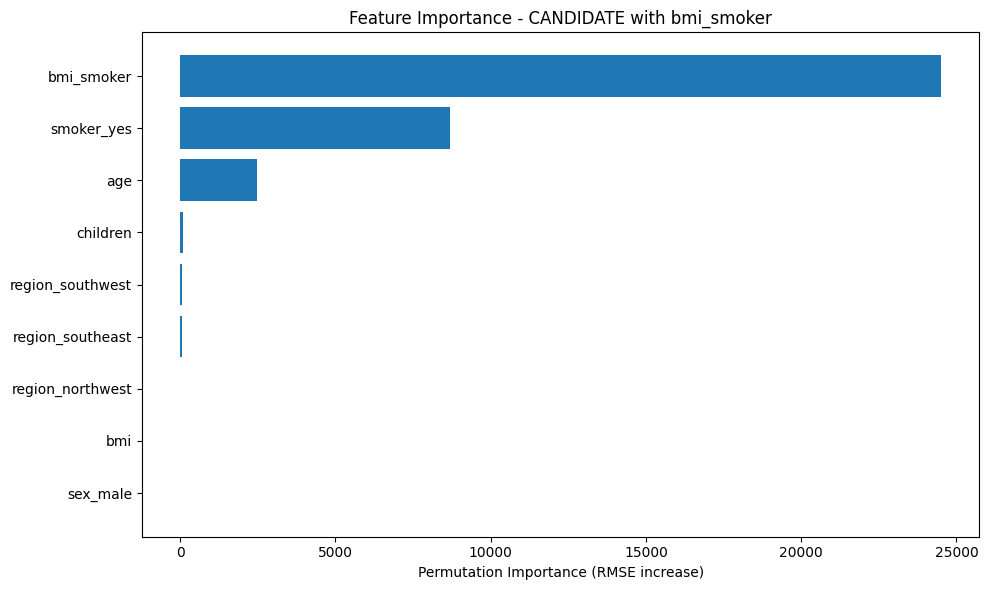

In [104]:
# ================================================================
# STEP 9: Permutation Importance Analysis
# ================================================================

def evaluate_permutation_importance(feature_names, label = "Model", n_repeats = 10):
    """
    Analyze the importance of features by the performance drop after shuffling values in a feature
    to be noisy.
    Importance = baseline performance - shuffled performance.
    Larger mean value is larger performance drop.

    Parameters:
    -----------
    feature_names: list
        The features to build and test permutation importance.
    label: str
        Label for the model being tested.
    n_repeats: int
        The number of times the feature is shuffled.

    Returns:
    --------
    results : dict
        Dictionary containing feature names and their importance scores.

    """
    print("\n" + "="*60)
    print(f"Permutation Importance: {label}")
    print("="*60)

    # ========================================================================
    # 1. Build out pipeline with custom classes
    # ========================================================================

    # Build features, preprocess based on datatype, and model
    pipeline = Pipeline(steps=[
        ("features",NotebookFeatureBuilder(feature_names)),
        ("preprocessor",DynamicPreprocessor()),
        ("model",LinearRegression())
    ])

    pipeline.fit(X_train,y_train)
    # ========================================================================
    # 2. Get instance of NotebookFeatureBuilder to get to X_train_preprocessed
    # ========================================================================
    # I want to assess the features after the preprocessing because OneHotEncoder creates new columns
    # Create an instance of NotebookFeatureBuilder to get the columns
    feature_builder = NotebookFeatureBuilder(feature_names)
    # Step through, so transform to get the selected features
    X_train_features = feature_builder.transform(X_train)
    # Then these selected features are passed into the preprocessor of the pipeline
    # Use named_steps to access the transform to get the preprocessed of X_train. Will need to mirror this for X_test for the importance.
    X_train_preprocessed = pipeline.named_steps['preprocessor'].transform(X_train_features)

    # ===================================================================================
    # 3. Get to preprocessor within pipeline to extract column names with .transformers_
    # ===================================================================================
    # Get the preprocessor to access the variables of the transformers_: (name, transformer, columns)
    preprocessor = pipeline.named_steps['preprocessor'].preprocessor
    # Store the names by initializing a list
    feature_names_out = []

    for name, transformer, columns in preprocessor.transformers_:
        # Want to add multiple names so extend the list (not append which is 1 object)
        if name == "num":
            feature_names_out.extend(columns)
        elif name == "cat":
            # get the feature names out from the transformer
            ohe_features = transformer.get_feature_names_out(columns)
            # extend those features
            feature_names_out.extend(ohe_features)

    # ========================================================================
    # 4. Get instance of NotebookFeatureBuilder to get to X_test_preprocessed
    # ========================================================================
    # Like the X_train to get X_train_preprocessed, we want to do that with test using the instance of NotebookFeatureBuilder
    X_test_features = feature_builder.transform(X_test)
    X_test_preprocessed = pipeline.named_steps['preprocessor'].transform(X_test_features)

    # ======================================================================================
    # 5. Permutation Importance - Outputs importances_mean, importances_std, and importances
    # ======================================================================================
    perm_importance = permutation_importance(
        pipeline.named_steps['model'],
        X_test_preprocessed,
        y_test,
        n_repeats = n_repeats,
        random_state = 42,
        scoring = 'neg_root_mean_squared_error'
    )

    # ========================================================================
    # 6. Permutation Importance - Reformatting and sorting by importance_mean
    # ========================================================================
    importances_df = pd.DataFrame({
        'features':feature_names_out,
        'importance_mean': perm_importance.importances_mean,
        'importance_std': perm_importance.importances_std
    }).sort_values(by='importance_mean', ascending=False)

    print("\nTop Features by Permutation Importance:")
    print(importances_df.to_string(index=False))

    # ========================================================================
    # 7. Visualize
    # ========================================================================

    plt.figure(figsize=(10,6))
    # barh and yticks take position for the first parameter then the value
    # range provides an array from 0 to the length of importances_df (highest value)
    # However, when the position is displayed, the highest number is displayed at the top
    # This is opposite of how we want our importances displayed -- reverse this later
    plt.barh(range(len(importances_df)),importances_df.importance_mean)
    # yticks is used to replace the position labels with the actual feature names
    plt.yticks(range(len(importances_df)),importances_df.features)
    plt.xlabel('Permutation Importance (RMSE increase)')
    plt.title(f'Feature Importance - {label}')
    # Importances are then reversed, so .invert_yaxis() is applied
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    return {
        'importance_df':importances_df,
        'raw_importances':perm_importance.importances,
        'features':feature_names_out
    }

results = evaluate_permutation_importance(candidate_feature_names,"CANDIDATE with bmi_smoker", n_repeats=10)

In [68]:
# Interpretation:
# ===========================
# Large drop => important
# Small drop => weak signal
# Near 0 => useless or redundant
# Negative (model improves) => feature is harmful noise

## Build Final Dataset

In [10]:
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1332,50,male,30.970,3,no,northwest,10600.54830
1333,18,female,31.920,0,no,northeast,2205.98080
1334,18,female,36.850,0,no,southeast,1629.83350
1335,21,female,25.800,0,no,southwest,2007.94500


In [12]:
# A peak into the built features - engineered without any encoding, scaling, or other data leakage effects.
# Combine this with the target and we can save it as the processed data.
df_features = build_features(df,candidate_feature_names)
df_features

,age,bmi,children,smoker,sex,region,bmi_smoker
0,19,27.900,0,yes,female,southwest,27.90
1,18,33.770,1,no,male,southeast,0.00
2,28,33.000,3,no,male,southeast,0.00
3,33,22.705,0,no,male,northwest,0.00
4,32,28.880,0,no,male,northwest,0.00
...,...,...,...,...,...,...,...
1332,50,30.970,3,no,male,northwest,0.00
1333,18,31.920,0,no,female,northeast,0.00
1334,18,36.850,0,no,female,southeast,0.00
1335,21,25.800,0,no,female,southwest,0.00


In [ ]:
# Note: Do not save features that have been encoded or scaled.
# 1. This is to prevent data leakage because encoder and scaler would see full dataset.
# 2. This would not be reproducible because NEW data would not match. We want to transform new data from scratch.
# 3. This would break model pipelines because of a train/predict mismatch.

# The train.py will use build_features.py and encoding/scaling happens here.

In [16]:
# Final Processed Dataset
df_processed = pd.concat([df_features,y],axis=1)
df_processed.to_csv(PROCESSED / "processed_insurance.csv",index=False)

## Observations

1. log_bmi does not add appreciable improvement compared to the complexity it brings.
2. age_sq does not improve it at all (note that age + age**2 was added in candidate vs baseline of age).
3. bmi_smoker is a great candidate as a feature w/ a 5/5 and overall improvement.
4. east and southeast only have marinal improvements and would not be good candidates.

#### bmi

We suspect right skew, let's plot a histogram to see. Then we can log transform bmi (within X) and charges (y) -- a functional transformation.

Text(0.5, 1.0, 'Histogram of Bmi')

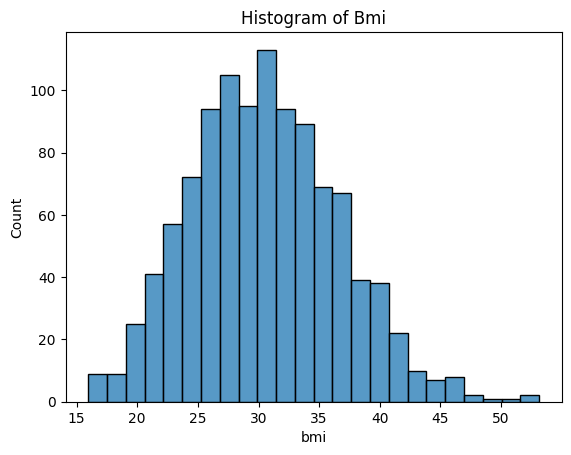

In [6]:
# Visualize
sns.histplot(X_train,x='bmi')
plt.title('Histogram of Bmi')

There is a right skew present that we can transform.

Text(0.5, 1.0, 'Log of Bmi')

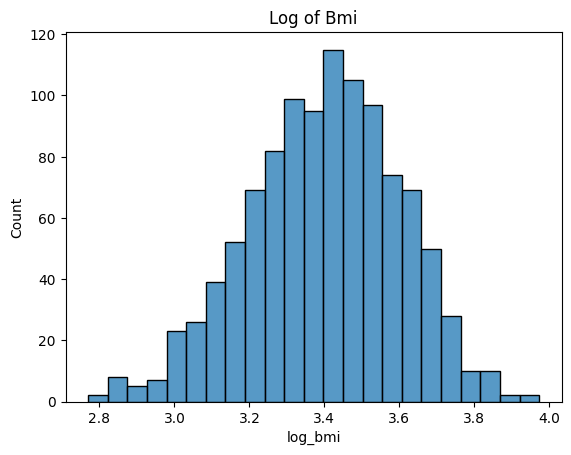

In [7]:
# Create a transformed column and visualize it
X_train['log_bmi'] = np.log(X_train['bmi'])
sns.histplot(X_train,x='log_bmi')
plt.title('Log of Bmi')

We now see that it is more symmetrical with less skew to the right.

In [8]:
# Drop it from X_train
# X_train = X_train.drop(columns='bmi')

# Within test: transform bmi to log_bmi and drop the original bmi column
X_test['log_bmi'] = np.log(X_test['bmi'])
# X_test = X_test.drop(columns=['bmi'])

#### charges

Text(0.5, 1.0, 'Histogram of Charges')

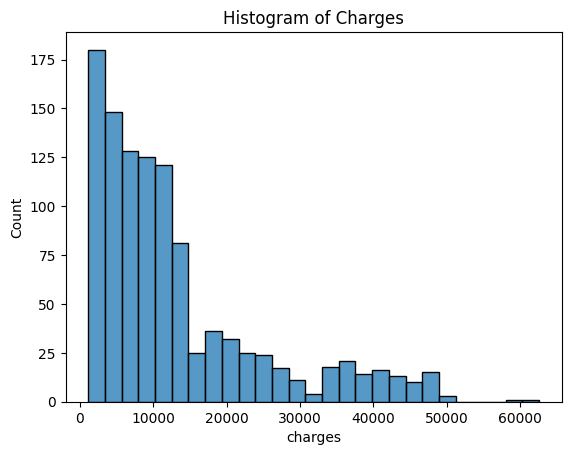

In [9]:
# Visualize
sns.histplot(y_train)
plt.title('Histogram of Charges')

There is a heavy right skew present we can transform.

In [10]:
y_train

1113     2396.09590
967      3279.86855
598     33471.97189
170     13405.39030
275      9715.84100
           ...     
1095    44641.19740
1130     3693.42800
1294     1964.78000
860      7151.09200
1126     5836.52040
Name: charges, Length: 1069, dtype: float64

In [14]:
y_train_log = np.log(y_train)
y_train_log = y_train_log.rename('log_charges')

In [16]:
y_train = pd.concat([y_train,y_train_log],axis=1)
y_train

,charges,log_charges
1113,2396.09590,7.781596
967,3279.86855,8.095559
598,33471.97189,10.418464
170,13405.39030,9.503412
275,9715.84100,9.181513
...,...,...
1095,44641.19740,10.706412
1130,3693.42800,8.214310
1294,1964.78000,7.583136
860,7151.09200,8.875020


Text(0.5, 1.0, 'log charges')

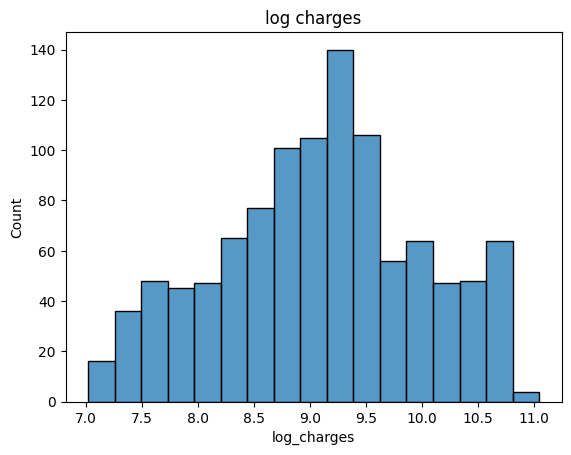

In [17]:
# Create a transformed column and visualize it
sns.histplot(y_train['log_charges'])
plt.title('log charges')

We see that the distribution is more symmetrical compared to its original heavy right skew. We can np.exp to get the original value later.

In [ ]:
# Transform y_test
y_test_log = np.log(y_test)
y_test_log = y_test_log.rename('log_charges')
y_test = pd.concat([y_test,y_test_log],axis=1)
